In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np
import pandas

In [2]:
torch.manual_seed(4)

In [18]:
def plot_channels(W):
    #number of output channels 
    n_out=W.shape[0]
    #number of input channels 
    n_in=W.shape[1]
    w_min=W.min().item()
    w_max=W.max().item()
    fig, axes = plt.subplots(n_out,n_in)
    fig.subplots_adjust(hspace = 0.1)
    out_index=0
    in_index=0
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
    
        if in_index>n_in-1:
            out_index=out_index+1
            in_index=0
              
        ax.imshow(W[out_index,in_index,:,:], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index=in_index+1

    plt.show()

In [4]:
def show_data(dataset, sample):
    plt.imshow(dataset.x[sample, 0, :, :].numpy(), cmap = 'gray')
    plt.title('y=' + str(dataset.y[sample].item()))
    plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, n_images = 100, offset = 0, p = 0.9, train = False):
        if train:
            np.random_seed(1)
        n_images = 2 * (n_images // 2)
        images = np.zeros((n_images, 1, 11, 11))
        start1 = 3
        start2 = 1
        self.y = torch.zeros(n_images).type(torch.long)
        for n in range(n_images):
            if offset > 0:
                low = int(np.random.randint(low = start1, high = start1 + offset, size = 1))
                high = int(np.random.randint(low = start2, high = start2 + offset, size = 1))
            else:
                low = 4
                high = 1
            if n <= n_images // 2:
                self.y[n] = 0
                images[n, 0, high:high + 9, low:low + 3] = np.random.binomial(1, p, (9, 3))
            elif n > n_images // 2:
                self.y[n] = 1
                images[n, 0, low:low + 3, high:high + 9] = np.random.binomial(1, p, (3, 9))
        self.x = torch.from_numpy(images).type(torch.FloatTensor)
        self.len = self.x.shape[0]
        del(images)
        np.random.seed(0)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [49]:
def plot_activations(a, number_rows = 1, name = ''):
    a = a[0, :, :, :].detach().numpy()
    n_activations = a.shape[0]
    print(n_activations)
    a_min = a.min().item()
    a_max = a.max().item()
    if n_activations == 1:
        plt.imshow(a[0, :], vmin = a_min, vmax = a_max, cmap = 'seismic')
    else:
        fig, axes = plt.subplots(number_rows, n_activations //number_rows)
        fig.subplots_adjust(hspace = 0.4)
        for i, ax in enumerate(axes.flat):
            if i < n_activations:
                ax.set_xlabel('activation:{0}'.format(i + 1))
                ax.imshow(a[i, :], vmin = a_min, vmax = a_max, cmap = 'seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()

In [12]:
def conv_output_shape(h_w, kernel_size = 1, stride = 1, pad = 0, dilation = 1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor(((h_w[0] + (2 * pad) - (dilation * (kernel_size[0] - 1)) - 1) / stride) + 1)
    w = floor(((h_w[1] + (2 * pad) - (dilation * (kernel_size[1] - 1)) - 1) / stride) + 1)
    return h, w

In [8]:
n_images = 10000
train_dataset = Data(n_images = n_images)
validation_dataset = Data(n_images = 1000, train = False)
train_dataset, validation_dataset

(<__main__.Data at 0x1bc93207048>, <__main__.Data at 0x1bc93207388>)

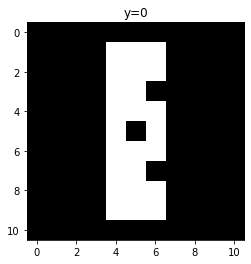

In [9]:
show_data(train_dataset, 0)

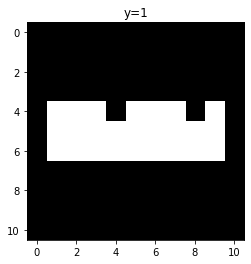

In [10]:
show_data(train_dataset, n_images // 2 + 2)

In [13]:
out = conv_output_shape((11, 11), kernel_size = 2, stride = 1, pad = 0, dilation = 1)
out1 = conv_output_shape(out, kernel_size = 2, stride = 1, pad = 0, dilation = 1)
out2 = conv_output_shape(out1, kernel_size = 2, stride = 1, pad = 0, dilation = 1)
out3 = conv_output_shape(out2, kernel_size = 2, stride = 1, pad = 0, dilation = 1)
out, out1, out2, out3

((10, 10), (9, 9), (8, 8), (7, 7))

In [31]:
class CNN(nn.Module):
    def __init__(self, out_1 = 2, out_2 = 1):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = out_1, kernel_size = 2, padding = 0)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 1)
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 2, stride = 1, padding = 0)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 1)
        self.fc1 = nn.Linear(out_2 * 7 * 7, 2)
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    def activations(self, x):
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out = self.maxpool2(a2)
        out = out.view(out.size(0), -1)
        return z1, a1, z2, a2, out

In [32]:
model = CNN(2, 1)
model

CNN(
  (cnn1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(2, 1, kernel_size=(2, 2), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49, out_features=2, bias=True)
)

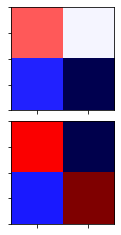

In [33]:
plot_channels(model.state_dict()['cnn1.weight'])

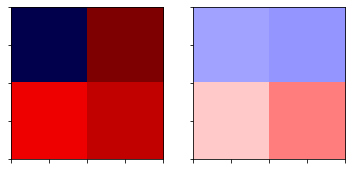

In [34]:
plot_channels(model.state_dict()['cnn2.weight'])

In [35]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 10)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 10)

In [36]:
epochs = 10
cost_list = []
accuracy_list = []
n_test = len(validation_dataset)
cost = 0
for epoch in range(epochs):
    cost = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost += loss.item()
    cost_list.append(cost)
    correct = 0
    for x_test, y_test in validation_loader:
        z = model(x_test)
        _, y_hat = torch.max(z.data, 1)
        correct += (y_hat == y_test).sum().item()
    accuracy = correct /n_test
    accuracy_list.append(accuracy)

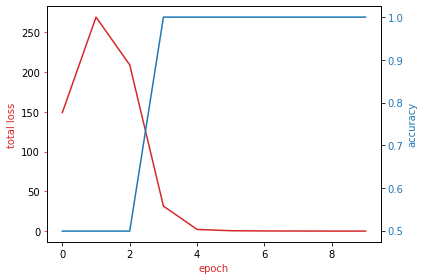

In [37]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

In [38]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.4724, -0.1010],
          [ 0.2049, -1.0581]]],


        [[[ 0.4593, -0.0119],
          [ 0.2661,  0.6561]]]])

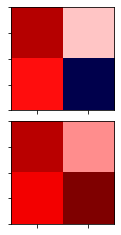

In [39]:
plot_channels(model.state_dict()['cnn1.weight'])

In [40]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.4724, -0.1010],
          [ 0.2049, -1.0581]]],


        [[[ 0.4593, -0.0119],
          [ 0.2661,  0.6561]]]])

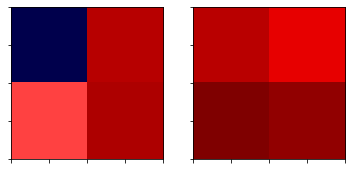

In [41]:
plot_channels(model.state_dict()['cnn2.weight'])

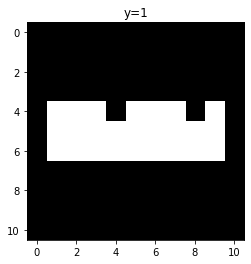

In [42]:
show_data(train_dataset, n_images // 2 + 2)

In [43]:
out = model.activations(train_dataset[n_images // 2 + 2][0].view(1, 1, 11, 11))
out = model.activations(train_dataset[0][0].view(1, 1, 11, 11))

2


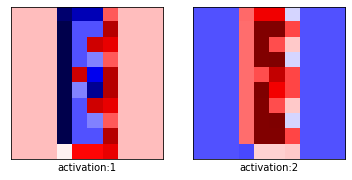

In [50]:
plot_activations(out[0], number_rows = 1, name = 'feature map')
plt.show()

1


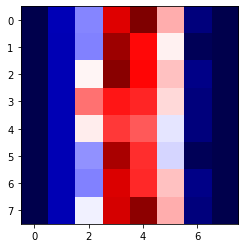

In [51]:
plot_activations(out[2], number_rows = 1, name = 'feature map')
plt.show()

1


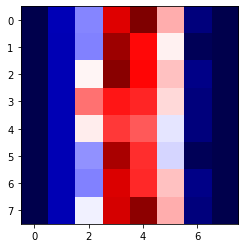

In [52]:
plot_activations(out[3], number_rows = 1, name = 'feature map')
plt.show()